# Grad-CAM
- https://github.com/betashort/pytorch-grad-cam/blob/master/gradcam.py

In [79]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Function

from torchvision import models

import matplotlib.pyplot as plt

In [21]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

## ResNet
- https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

## PyTorch's Global Pooling
https://www.テクめも.com/entry/pytorch-pooling


- adaptive_max_pool2d(x, (1,1)
- adaptive_avg_pool2d(x, (1,1))

ResNetのConv層=>Dense層は、adaptive_avg_pool2d((1,1))になっているので、Global Average Poolingである。

In [22]:
image_path = "../picture/dog_1.jpg"

# FeatureExtractor

In [108]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        #self.model._modules.items() => 
        #https://blog.snowhork.com/2018/08/pytorch-parameters
        #torch.nn.Moduleは， __init__ 時に，
        #_parameters と _modules というインスタンス変数を OrderedDict で初期化しています
        #_modulesは、変数名,　構成する層が解ってくる
        
        for name, module in self.model._modules.items():
            x = module(x)
            
            '''
            #register_hookとは？
            #特定の学習時間におけるパラメータの特定の誤差を記録することができる
            #勾配の記録 => target_layersの勾配
            
            #target_layersは、["2"]と設定している
            #modelは、model.layer4になっている。(layer4はResブロック(Conv層)の最後のブロック)
            #model.layer4は下のような構造になっている
            
            Sequential(
                (0): Bottleneck(省略)
                (1): Bottleneck()
                (2): Bottleneck()
            )
            
            for name, module in self.model._modules.items():
            
            nameは、(0), (1), (2)
            moduleは、Bottleneck, ...
            になっているので、 if name in self.target_layers:は、Resブロックの最終層を示している。
            Resブロックの最終層の勾配を記録する
            記録する関数として save_gradientが定義されていて、伝播した際に作動するようになっている
            '''
            if name in self.target_layers:
                print(self.target_layers)
                print(name)
                x.register_hook(self.save_gradient)
                outputs += [x]
                print("output")
        return outputs, x

In [118]:
for name, module in feature_module._modules.items():
    '''
    if name in target_layer_names:
        print("===== module =====")
        print(name)
        print(module)
    '''

In [119]:
feature_module

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

# ModelOutputs

In [110]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        #feature_module => model.layer4
        #
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        #
        target_activations = []
        
        for name, module in self.model._modules.items():
            #
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


In [111]:
x = input

target_activations = []
for name, module in model._modules.items():
    #順伝播
    print('====== module ======')
    print(f'name : {name}')
    print(f'module : {module}')

    if module == feature_module:
         target_activations, x = self.feature_extractor(x)
    elif "avgpool" in name.lower():
        x = module(x)
        x = x.view(x.size(0),-1)
    else:
        x = module(x)

====== module ======
name : conv1
module : Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'weight'

# Grad-CAM

In [112]:
#class GradCam
#def __init__(self, model, feature_module, target_layer_names, use_cuda):
#model => resnet50
#feature_module=model.layer4
#target_layer_names => ["2"]
model = models.resnet50(pretrained=True)

feature_module=model.layer4
target_layer_names=["2"]
use_cuda=True

#feature_module => ResNetのlayer4は、最終のCov層
#https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
#target_layer_names =>
#use_cuda => GPUの話

#==== 画像の読み込みと前処理 ====
img = cv2.imread(image_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)


In [113]:
model.eval()
cuda = use_cuda
if use_cuda:
    model = model.cuda()

In [114]:
extractor = ModelOutputs(model, feature_module, target_layer_names)

In [115]:
if use_cuda:
    features, output = extractor(input.cuda())
else:
    features, output = extractor(input)

['2']
2
output


In [116]:
len(features)

1

In [39]:
output.size()

torch.Size([1, 1000])

In [60]:
#index(ラベル)を取得する
index = None
if index == None:
    index = np.argmax(output.cpu().data.numpy())
        
one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
#targetのインデックスに1をする
one_hot[0][index] = 1
#torch型に変換
one_hot = torch.from_numpy(one_hot).requires_grad_(True)

In [61]:
one_hot

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [62]:
if use_cuda:
    one_hot = torch.sum(one_hot.cuda() * output)
else:
    one_hot = torch.sum(one_hot * output)

In [63]:
one_hot

tensor(11.7226, device='cuda:0', grad_fn=<SumBackward0>)

In [64]:
feature_module.zero_grad()
model.zero_grad()
one_hot.backward(retain_graph=True)

In [65]:
grads_val = extractor.get_gradients()[-1].cpu().data.numpy()

In [67]:
grads_val.shape

(1, 2048, 7, 7)

In [70]:
target = features[-1]
target = target.cpu().data.numpy()[0, :]

In [71]:
target

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.23257053e+00, ...,
         2.80910754e+00, 1.98768580e+00, 6.48559690e-01],
        [5.22816628e-02, 1.41330525e-01, 6.71098173e-01, ...,
         1.35484397e+00, 1.27554464e+00, 7.28429496e-01],
        [0.00000000e+00, 0.00000000e+00, 9.45669949e-01, ...,
         2.16343403e+00, 1.14494848e+00, 4.96363007e-02]],

       [[0.00000000e+00, 6.25990890e-03, 3.32565308e-02, ...,
         1.58997819e-01, 3.59049439e-02, 0.00000000e+00],
        [0.00000000e+00, 2.98277944e-01, 9.51430500e-01, ...,
         1.95068598e+00, 9.86407161e-01, 1.91305131e-01],
        [5.42861879e-01, 

In [76]:
weights = np.mean(grads_val, axis=(2, 3))[0, :]
cam = np.zeros(target.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * target[i, :, :]

In [77]:
print(weights.shape)
weights


(2048,)


array([ 4.6442935e-04, -5.8028055e-04,  1.3206062e-04, ...,
       -3.9998742e-04, -5.2839745e-04,  5.2257412e-05], dtype=float32)

In [78]:
cam

array([[ 1.9310256e-02, -1.0418791e-03,  2.5255228e-03,  1.2409778e-03,
        -9.1478036e-04, -1.4765374e-02, -3.6453553e-02],
       [ 1.6480299e-02, -1.2409224e-02,  1.3208895e-02,  4.1725580e-02,
         4.6291471e-02,  3.3253744e-02, -6.6142664e-03],
       [-1.7355233e-02, -1.5521324e-02,  1.2494148e-02,  6.5762818e-02,
         7.3054105e-02,  4.2248566e-02, -1.1418818e-02],
       [-7.0440532e-03,  2.4084331e-02,  2.9429266e-01,  4.9937579e-01,
         5.0822043e-01,  2.0778300e-01,  7.4148901e-02],
       [ 1.7305808e-02,  6.8977468e-02,  7.2212136e-01,  1.0049548e+00,
         9.7048926e-01,  5.8894384e-01,  2.0775680e-01],
       [ 3.1328131e-02,  1.1428761e-01,  8.0242336e-01,  9.5199054e-01,
         1.0995246e+00,  5.8228886e-01,  1.8430956e-01],
       [ 4.3638289e-02,  7.0940413e-02,  5.2069616e-01,  6.6666341e-01,
         7.3137558e-01,  3.7156957e-01,  1.2225814e-01]], dtype=float32)

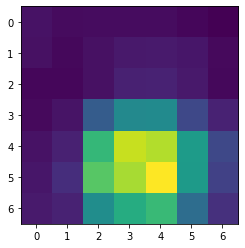

In [80]:
plt.imshow(cam)

In [81]:
cam = np.maximum(cam, 0)
cam = cv2.resize(cam, input.shape[2:])
cam = cam - np.min(cam)
cam = cam / np.max(cam)

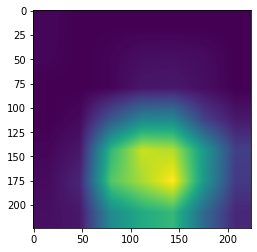

In [82]:
plt.imshow(cam)

In [27]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

In [29]:
# Can work with any model, but it assumes that the model has a
# feature method, and a classifier method,
# as in the VGG models in torchvision.






AttributeError: 'ResNet' object has no attribute 'classifier'